(section4.2)=
# 4.2 Fitting (Regression) Models

In the previous section we learned about parameters representing mathematical elements of data. One way to think of models are that they are collection of parameters.

In order to use models to learn about data we need to tweak the parameter values so that the model is an adequate representation of the data.

This is called **fitting** a model to data.

We fit a model by minimising a **cost function**. A cost function can be any function where higher values mean that the model evaluated on the estimated parameters are less representative of data.

Let us illustrate this by using a very simple and familiar single-parameter model: _the mean_. 


## The mean as a model 

Let us have a dataset consisting of one random variable, $Y$. We wish to represent this dataset as best we can with a single parameter on the same arithmetic scale as the data: $\mu$.

We first define a cost function. Since $\mu$ is meant to be a single quantity that represents the data we want values that a further away to $\mu$ to have a higher cost. As we don't want negative values we could square the error, this will also have the added benefit of penalising higher errors more harshly than lower errors. We can sum all the **squared errors** of each data point from $\mu$ to get a single value that we could minimise. 

$$\sum (Y-\mu)^2$$ 

However, this value is in squared error units, which is unintuitive. To keep the cost function in the units of the data we can take the average then take the square root. This gives us a common cost function, **root-mean-squared-error** (RMSE):

$$\sqrt{\frac{1}{n}\sum (Y-\mu)^2}$$

Essentially, we fit this model by trying different predictions for $\mu$, calculating the cost, and selecting the value of $\mu$ that has the minimum cost.

In this case the minimum of this cost function corresponds exactly to the mean (with some sampling variability).

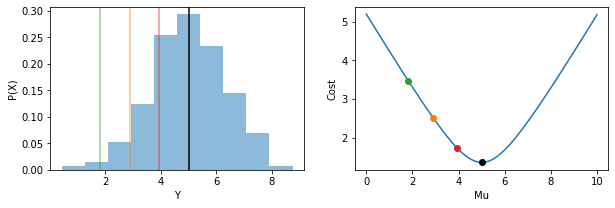

Mean: 5.009448482367973, Mu: 5.01


In [81]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
colors = ['C1','C2','C3'] #https://matplotlib.org/stable/users/dflt_style_changes.html

### generate fake data.
n = 500
b0 = 2
b1 = .3
variable = np.linspace(5,15,n)
resids = norm.rvs(0,1,n)
data = np.array(b0+b1*variable+resids)

### set predictions for mu
mu = np.linspace(0,10,1000)

### calculate costs
def cost(X, mu):
    return np.sqrt(np.mean((X-mu)**2))

costs = [cost(data, m) for m in mu]



fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].hist(data, density=True, alpha=.5)
ax[0].set_xlabel('Y')
ax[0].set_ylabel('P(X)')
ax[0].axvline(np.mean(data),c='k')
ax[1].plot(mu,costs)
ax[1].plot(mu[np.argmin(costs)], min(costs), 'ok')
ax[1].set_ylabel('Cost')
ax[1].set_xlabel('Mu')


# add some sample lines
mu_index = np.random.randint(n, size=3)
for (i, mu_i) in enumerate(mu_index):
    ax[0].axvline(mu[mu_i], color=colors[i], alpha=.5)
    ax[1].plot(mu[mu_i],costs[mu_i], 'o', color=colors[i])

plt.show()

print(f"Mean: {np.mean(data)}, Mu: {round(mu[np.argmin(costs)],2)}")

The mean is a poor model when you want to capture the data distribution since it predicts the same value each time.

One of the most common probablistic approaches is to model the data points as coming from a [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution). A normal (or Gaussian) distribution arises in cases where a continuous random variable has symetrical variability around a mean.

We fit a normal distribution to our data similarly to our previous example: we find the parameter values that are demonstrably best with respect to some cost function.

A common cost function for fitting probability distributions is the **likelihood**. Simply put, a likelihood of a single data point is the probability of that data point occurring given a probability distribution with certain parameters. The combined likelihood of a dataset is each individual likelihood multiplied together. A common fitting technique is to find the **maximum likelihood** of a dataset. 

In practice getting the combined likelihood of a dataset is computationally infeasible (since the multiplied numbers are very small), therefore the **log-likelihood** is taken so that we can sum across the data points. Further, taking the _negative_ log-likelihood allows us to use _minimisation_ algorithms. So, when you read _maximum likelihood estimation_ the authors are normally talking about _minimising the negative log-likelihood_. 

The **log-likelihood** is illustrated below with our previous fake dataset. To make the illustration simpler we have fixed the Gaussian standard deviation parameter.

Maximum Likelihood: 0.0


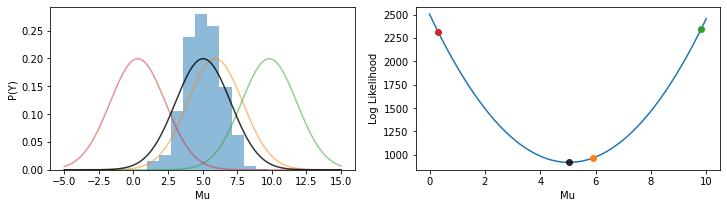

In [74]:
sigma = 2
n = 1000
mu = np.linspace(0,10,1000)
test_range = np.linspace(-5,15,10000)

#calculate likelihoods, will be all zeros because the values are so small
likelihoods = np.array([np.multiply.reduce(norm.pdf(data, loc=m, scale=sigma)) for m in mu])
print(f"Maximum Likelihood: {max(likelihoods)}") 

# so we take the negative log-likelihood .
logliks = np.array([np.sum(-norm.logpdf(data, loc=m, scale=sigma)) for m in mu])

fig, axes = plt.subplots(1,2, figsize=(12,4))

axes[0].hist(data, density=True, alpha=.5)
axes[0].set_ylabel('P(Y)')
axes[0].set_xlabel('Mu')
axes[1].plot(mu, logliks)
axes[1].set_ylabel('Log Likelihood')
axes[1].set_xlabel('Mu')


# calculate example gaussians
mu_index = np.random.randint(n, size=3)
for (i, mu_i) in enumerate(mu_index):
    axes[0].plot(test_range, norm.pdf(test_range, loc=mu[mu_i], scale=sigma), color=colors[i], alpha = .5)
    axes[1].plot(mu[mu_i],logliks[mu_i], 'o', color=colors[i])
    
# plot minimum log-lik (maximum likeilhood)
mu_min = mu[np.argmin(logliks)]
axes[0].plot(test_range, norm.pdf(test_range, loc=mu_min, scale=sigma), color='k', alpha = .8)
axes[1].plot(mu_min, min(logliks), 'o', color='k', alpha = .8)

plt.show()

## Modelling relationships: Regression. 

So far we have been modelling observations of a single variable, $Y$ as coming from a normal distribution with a mean, $\mu$, and a standard deviation, $\sigma$

$ Y \sim Normal(\mu,\sigma) $.

Most research questions are interested in modelling relationships between variables. Instead of modelling directly the parameters of a distribution we can make the parameters _dependent_ on other variables.

We call our other variable $X$. Since we already are under the assumption that $Y$ varies around a mean, it stands to reason that we would model the _mean_ as changing with $X$, accepting that $Y$ would vary around this new moving average. The simplest method of modelling relationships is to assume that the mean of $Y$ varies _linearly_ with $X$. Meaning that one capture the relationship by a line with an intercept and a slope.



$ \mu = \beta_0 + \beta_1X $

Here, $\beta_0$ is the intercept, meaning the value that $Y$ would take when $X=0$, and $\beta_1$ is a parameter that scales how much a change in $X$ corresponds to the change in $Y$. An alternative common way of writing this is:

It is convention in Regression models to have your input variables as a matrix $X_{ni}$ and your predicted values as $Y_i$, where $n$ refers to the variable index and $i$ refers to the observation index. The parameters are often stored as a vector $\beta$

$ Y_i = \beta_0 + \beta_1X_i + \epsilon $,

where $\epsilon$ refers to **residual error** that is normally distributed around zero: $\epsilon \sim Normal(0,\sigma)$, and $i$ refers to the observation. You can also write this as:

$ Y_i = Normal(\beta_0 + \beta_1X_i, \sigma) $

Modelling in this way is called **Linear Regression**. Parameters that scale the relationship between an input variable to an output variable are called **Coefficients**.

Modelling one variable as dependent on another variable is (a little confusingly) called _regression_ after Francis Galton originally described the method when reporting the phenomenon of _regression to the mean_ ([Regression Analysis wikipedia page](https://en.wikipedia.org/wiki/Regression_analysis)). This does make some sense in the general statistical context, if you think of _Regression_ referring to the notion of finding the mean line that points vary around (or regress to).



Each input to your model has an associated parameter called a **coefficient**. Two important things to remember:

- Coefficients can be thought of as a mini-hypothesis: given that I know all the other inputs to the model, what how much does this input contribute to the output? In the case of our simple example, the coefficient $\beta_1$ specifies how much the input variable contributes to the output variable _only_ once the intercept is known.

- Coefficients scale your input so are dependent on the magnitude of our input. The larger your input, the smaller your coefficient. If you wish to compare coefficients across input variables you need your input variables to be on a similar scale. This is called _standardising_ your inputs.


We will now tweak our previous code to fit this new regression model via maximum likelihood, as we have been doing. 

1) You can analytically find the intercept given the coefficients. Rearranging the formula above gives $Y - \beta_1X = \beta_0 + \epsilon$. Since this is identical to $Normal(\beta_0, \epsilon)$, averaging retrieves $\beta_0$. 
2) The _dot product_ of an input matrix $X$ and a vector of parameters $\beta$ is a quick way of finding the predicted values. Essentially the dot product multiplies the $X_n$ by each $\beta_n$ and sums the result.

For normal linear regression there is actually an analytic [ordinary least squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) solution to finding the maximum likelihood, but to be consistent we will emphasis finding the parameter values through minimising the negative log-likelihood.



Since our example is simple (only two fitted parameters) we can do an exhaustive search of the parameter space (up to a level of granularity) and find the minimum negative log-likelihood. This method of fitting is intractable for more complicated models where the parameters space is larger. Optimisation algorithms for effectively exploring a parameter space (that may have constraints) and finding the minimum of a cost function is a big field with active research. Fortunately, the available statistical packages use well-established algorithms that perform well for most models. For this introductory course, then, we will treat the optimisation algorithm as an unnecessary implementation detail. Note, however, that for your own research you may run into issues with complex models that requires further knowledge of how the parameter space is explored. 


Intercept: 1.8132522861717772
Slope: 0.3196196196196196


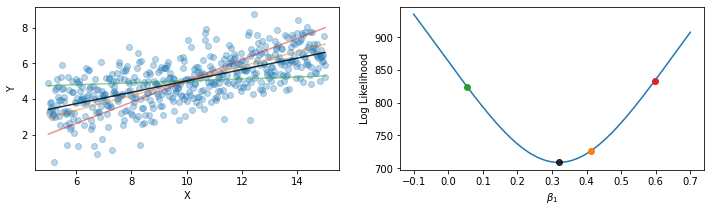

In [84]:
###  Code block to fit the linear regression model with MLE.
###  See "Code Preliminaries" margin note for useful tips for following this code.

n = 1000
b1s = np.linspace(b1-.4,b1+.4, n)
X = variable
Y = data

def get_intercept(X, Y, b1):
    return np.average(Y - (X*b1))

def predict(X, Y, b1):
    return X*b1 + get_intercept(X,Y,b1)

def negloglik(predictions, Y, verbose=False):
    residuals = predictions - Y
    stdev = np.sqrt(np.average(residuals**2))
    loglik = np.sum(norm.logpdf(Y, loc=predictions, scale=stdev))
    return loglik*-1
    
def fit(X, Y, b1, verbose=False):
    predictions = predict(X, Y, b1)
    return negloglik(predictions, Y, verbose=verbose)
    
# retrieve logliks for each
logliks = [fit(X, data, b1) for b1 in b1s]


fig, axes = plt.subplots(1,2, figsize=(12,4))

axes[0].scatter(X,data, alpha=.3)
axes[0].set_ylabel('Y')
axes[0].set_xlabel('X')

axes[1].plot(b1s, logliks)
axes[1].set_ylabel('Log Likelihood')
axes[1].set_xlabel(r'$\beta_1$')


# pick example coefficients
b1_index = np.random.randint(n, size=3)
for (i, b1_i) in enumerate(b1_index):
    axes[0].plot(X, predict(X, Y, b1s[b1_i]), '-', color=colors[i], alpha = .5)
    axes[1].plot(b1s[b1_i],logliks[b1_i], 'o', color=colors[i])
    
# plot minimum log-lik (maximum likeilhood)
b1_min = b1s[np.argmin(logliks)]
axes[0].plot(X, predict(X, Y, b1_min), '-k', alpha = .8)
axes[1].plot(b1_min, min(logliks), 'ok', alpha = .8)
print(f'Intercept: {get_intercept(X,Y,b1_min)}')
print(f'Slope: {b1_min}')
plt.show()


### How many parameters?

You get more complex models by adding more variables, and perhaps mathematically specifying the nature of the relationship between variables (e.g., if we assume modulation of one variable with another we might multiply them together). The linear regression formula for $n$ parameters is below.

$$
Y = \beta_0 + \beta_1 x_{1} + \beta_2 x_{2} + ...+ \beta_n x_{n} +  \epsilon
$$

The amount of parameters depends what you are interested in and what you want to learn. 

With enough parameters you can fit anything. But there is risk that we could just be fitting to noise. For example, if a designer was modelling a product they wouldn't want to include a scratch on one particular product that arose from the randomness of the production process.

This phenomenon is called **overfitting**. It is a key consideration in modelling and we will be revisiting it frequently throughout the following sections.

Bishop's [Machine Learning for Pattern Recognition](http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf) textbook has an instructive example on fitting curves of increasing complexity. This has been usefully translated to a python notebook by Mantas Lukoševičius ([link](https://mantas.info/wp/wp-content/uploads/learn/curve-over-fitting.html)). 


Regularisation refers to a set of methods that help combat overfitting. Broadly speaking, overfitting arises when coefficients are too large or where there are too many parameters. Regularisation techniques often add a term to the cost function that is dependent on either the number or the magnitude (or both) of the coefficient parameters. Therefore, many and large coefficients are penalised. Fewer and smaller coefficients make for a more conservative model fit. (Though too few and/or small coefficients can lead to underfitting). 


## Beyond Normal Linear Regression

It is important to keep in mind that the normal linear regression equation above is the following: 

$$ Y \sim Normal(\beta_0 + \beta_1 x_{1} + \beta_2 x_{2} + ...+ \beta_n x_{n}, \sigma) $$

The **linear regression** part refers to modelling a parameter, in this case the mean, as a **sum of scaled inputs**. There is actually no requirement in linear regression models for the modelled output to be linear.

There is also no requirement for you to assume that the errors will be normally distributed around the mean. With MLE you can model the errors as coming from a wide range of probability distributions (the _exponential family_). Indeed, your model complexity is in theory only limited by your ability to fit the model.


Let us zoom out and look at the components of our model so far:

1) We have the term that is predicting $\mu$. This is called the **linear predictor**, let us call this $\eta$, which is a sum of inputs $X$ scaled by coefficients, $\beta$, which are unknown. 
2) We have a probability distribution, let us call it $F$, and sometimes a dispersion parameter (called $\tau$ to separate it from the guassian-specific standard deviation parameter $\sigma$). The probability distribution controls how our residuals are distributed.


So we can re-write our model as a **generalized** linear model:

$$ Y = F(\eta, \tau) $$

The linear predictor $\eta$ is always related to $\mu$, but it can do via a **link function**, $g$, meaning: 

$$ \eta = g(\mu) $$

You can recover $\mu$ by applying the inverse of the link function, $g^{-1}$ to the $\eta$.

$$ \mu = g^{-1}(\eta) $$

So the general case is:

$$ Y = F(g^{-1}(\eta),\tau) $$

In normal linear regression, $F = Normal$, $\tau = \sigma$, and $g$ is the identity function, meaning $g(\mu)=\mu$. 




## From linear regression to logistic regression.

From [_Section 4.1_](section4.1) and [_Section 4.2_](section4.2) so far we are familiar with the following:

- Linear regression where the residuals are gaussian
- The generalised regression framework
- The bernouilli distribution for modelling binary outcomes.

The gaussian distribution is useful when the output variable is continuous and symmetrically distributed. If we want to regress a binary variable onto predictors (i.e. find a mean line that the residuals vary around) then we need to consider the bernouilli distribution.

Remember our general framework of a probability distribution, $F$, a linear predictor $\eta$, a link function $g$, and a dispersion parameter $\tau$: 

$$ Y = F(g^{-1}(\eta),\tau) $$

Remember that the bernouilli is fairly special in having a single parameter, $p(x)$. There is no dispersion parameter. So:

$$
\begin{aligned}
Y &= F(g^{-1}(\eta)) \\
g^{-1}(\eta) &= p(x) \\
\eta &= g(p(x))
\end{aligned}
$$


In logistic regression instead of modelling $\mu$ on the arithmetic scale, as in normal regression, we use the **log-odds** to model the mean in _logistic units_, which is why it is sometimes called the **logit** function. So our link function transforms the linear predictor $\eta$ into log-odds:

$$ logodds(p) = log( \frac{p}{1-p}) $$

Which results in what we call the **logistic regression** model

$$\log\left(\frac{p({\bf x})}{1 - p({\bf x})}\right) = \beta_0 + \beta_1 x_1 + \ldots  + \beta_{n} x_{n} $$

Recall that $p(x)$ is bounded between 0 and 1, since it is a probability. We can transform log-odds to the probability range $\{0,1\}$ by the [**sigmoid**](https://en.wikipedia.org/wiki/Sigmoid_function) function, or **inverse-logit**:

$$
\text{logit}^{-1}(Y) =  \frac{e^Y}{1 + e^{Y}} = \frac{1}{1 + e^{-Y}} 
$$

Meaning you can get $p(x)$ directly from the predictor variables.

$$
p({\bf x}) = \frac{e^{\beta_0 + \beta_1 x_{1} + \cdots + \beta_{n} x_{n}}}{1 + e^{\beta_0 + \beta_1 x_{1} + \cdots + \beta_{n} x_{(n)}}} = \frac{1}{1+e^{-\beta_0 + \beta_1 x_{1} + \cdots + \beta_{n} x_{n}}}
$$


In our general framework, $g = logit$, $g^{-1} = sigmoid $.

It may seem strange to model the log-odds. In the next section we will step through why this is the case as we use logistic regression to dive into our research question.